<h1>Лабораторна робота #4</h1>
<h2>Структури для роботи з великими обсягами даних в Python</h2>
<h3>Виконав: Воронюк Володимир ФБ-24</h3>
<p>
  <b>Мета:</b> отримати навички роботи із структурами для зберігання в Python
  (python, numpy, pandas, numpy array, dataframe, timeit)
</p>
<p>
  <b>Основні поняття:</b> numpy масиви, кортежі, списки, фрейми,
  профілювання.
</p>

<h4>Перший рівень (спрощені завдання)</h4>
<h5>Завдання першого рівня</h5>

<p>
  Виконати всі завдання, використовуючи як numpy array, так і
  dataframe, проаналізувати часові витрати на виконання процедур
  (профілювання часу виконання), зробити висновки щодо ситуацій, в яких
  має сенс віддати перевагу тій чи іншій структурі даних. Висновки оформити
  звітом із зазначеним часом виконання та оцінкою по 5-бальній шкалі
  зручності виконання операцій відбору.
</p>
<p>
  Також варто звернути увагу на те, що дані, як і практично все в реальному
  житті, можуть потребувати Вашої уваги - потрібно залишити лише ті
  спостереження, в яких немає порожніх спостережень (порожні значення –
  пусті поля між роздільником – ? – 28.04.2007, як приклад).
<p>
<ol>
  <li>
    Обрати всі домогосподарства, у яких загальна активна споживана
    потужність перевищує 5 кВт.
  </li>
  <li>
    Обрати всі домогосподарства, у яких вольтаж перевищую 235 В.
  </li>
  <li>
    Обрати всі домогосподарства, у яких сила струму лежить в межах
    19-20 А, для них виявити ті, у яких пральна машина та холодильних
    споживають більше, ніж бойлер та кондиціонер.
  </li>
  <li>
    Обрати випадковим чином 500000 домогосподарств (без повторів
    елементів вибірки), для них обчислити середні величини усіх 3-х
    груп споживання електричної енергії, а також
  </li>
  <li>
    Обрати ті домогосподарства, які після 18-00 споживають понад 6
    кВт за хвилину в середньому, серед відібраних визначити ті, у яких
    основне споживання електроенергії у вказаний проміжок часу
    припадає на пральну машину, сушарку, холодильник та освітлення
    (група 2 є найбільшою), а потім обрати кожен третій результат із
    першої половини та кожен четвертий результат із другої половини.
  </li>
</ol>

In [1]:
import os
import shutil
from io import BytesIO
from urllib.request import urlopen, Request
from urllib.error import HTTPError
from zipfile import ZipFile, BadZipFile
from datetime import datetime

import pandas as pd
import numpy as np
import csv

from tabulate import tabulate

import seaborn as sns
import matplotlib.pyplot as plt

from scipy.stats import pearsonr, spearmanr
from sklearn.preprocessing import OneHotEncoder

import timeit

In [2]:
class Data:
    def __init__(
            self,
            data_directory: str,
            data_filename_part: str,
            data_link: str, 
            data_archive_name: str,
            existing_data_filename: str, 
            ):
        self.data_directory = data_directory
        self.data_filename_part = data_filename_part 
        self.data_filename = existing_data_filename
        self.data_filepath = os.path.join(self.data_directory, self.data_filename) if self.data_filename is not None else None
        self.data_link = data_link
        self.data_archive_name = data_archive_name

        self.data_pd = None
        self.data_np = None

    
    def ClearDataDir(self):
        for filename in os.listdir(self.data_directory):
            filepath = os.path.join(self.data_directory, filename)
            try:
                if os.path.isfile(filepath) or os.path.islink(filepath):
                    os.unlink(filepath)
                elif os.path.isdir(filepath):
                    shutil.rmtree(filepath)
            except Exception as e:
                print(f"Failed to delete {filepath}. Reason: {e}")
    
    def DeleteDataFile(self):
        if self.data_filepath is None:
            return

        try:
            os.unlink(self.data_filepath)
        except Exception as e:
            print(f"Failed to delete {self.data_filepath}. Reason: {e}")
    
    def Download(self):
        try:    
            if not os.path.isdir(self.data_directory):
                print(f"Directory '{self.data_directory}' does not exist. Creating one new.")
                os.mkdir(self.data_directory)
            
            self.DeleteDataFile()

            # Завантажуємо архів із даними
            request = Request(self.data_link, method="GET")
            responce = urlopen(request)
            datazip = ZipFile(BytesIO(responce.read()))
            # file_names = datazip.namelist()

            # # В архіві був один файл, тому робимо таку перевірку
            # if len(file_names) != 1:
            #     raise RuntimeError("One file in zip archive exptected")

            # # Відкриваємо файл із архіву
            # data_name = file_names[0]
            # data_file = datazip.open(data_name)
            data_file = datazip.open(self.data_archive_name)

            data_file_content = data_file.read()

            # Формуємо для нього ім'я та шлях, щоб потім його можна було відкрити
            # та зчитати
            curr_datetime = datetime.now().strftime("%Y%m%d%H%M%S")
            self.data_filename = f"{self.data_filename_part}_{curr_datetime}.csv"
            self.data_filepath = os.path.join(self.data_directory, self.data_filename)

            # Створюємо новий файл і записуємо вміст файлу з даними із архіву
            data_local_file = open(self.data_filepath, 'wb')
            data_local_file.write(data_file_content)

            #Закриваємо всі відкрити раніше файли
            datazip.close()
            data_file.close()
            data_local_file.close()

        except HTTPError as e:
            print(f"Error code: {e.code}")
            print(e.read())
        except BadZipFile as e:
            print(e)
        except RuntimeError as e:
            print(e)
        
    

class DataPart1(Data): 
    def PrepareDataPD(self):
        df = pd.read_csv(
            self.data_filepath,
            #names=headers,
            #dtype=dtypes,
            #parse_dates=[["Date", "Time"]],
            sep=';',
            na_values=['?']
        )
        
        df = df.convert_dtypes()
        df["DateTime"] = pd.to_datetime(df["Date"] + ' ' + df["Time"], dayfirst=True, format="%d/%m/%Y %H:%M:%S")
        df.drop(columns=["Date", "Time"], inplace=True)

        df = df[[
            "DateTime", "Global_active_power", 
            "Global_reactive_power", "Voltage", "Global_intensity",
            "Sub_metering_1", "Sub_metering_2" , "Sub_metering_3"
        ]]
  
        self.data_pd = df


    def GetDataPD(self):
        if self.data_pd is None:
            self.PrepareDataPD()
        return self.data_pd

    def convert_datetime(self, date, time):
        datetime_str = f"{date} {time}"
        return np.datetime64(datetime.strptime(datetime_str, '%d/%m/%Y %H:%M:%S'))

    def PrepareDataNP(self):
        dtypes = [
            ('DateTime', 'datetime64[s]'),
            ('Global_active_power', 'f8'),
            ('Global_reactive_power', 'f8'),
            ('Voltage', 'f8'),
            ('Global_intensity', 'f8'),
            ('Sub_metering_1', 'f8'),
            ('Sub_metering_2', 'f8'),
            ('Sub_metering_3', 'f8')
        ]

        data_np_tmp = np.genfromtxt(
            self.data_filepath,
            delimiter=';',
            dtype=None,
            names=True,
            encoding=None
        )

        date_time = np.array([self.convert_datetime(row['Date'], row['Time']) for row in data_np_tmp])
        na_value = '?'

        self.data_np = np.zeros(data_np_tmp.shape, dtype=dtypes)
        self.data_np['DateTime'] = date_time

        self.data_np['Global_active_power'] = np.where(data_np_tmp['Global_active_power'] == na_value, np.nan, data_np_tmp['Global_active_power'])
        self.data_np['Global_reactive_power'] = np.where(data_np_tmp['Global_reactive_power'] == na_value, np.nan, data_np_tmp['Global_reactive_power'])
        self.data_np['Voltage'] = np.where(data_np_tmp['Voltage'] == na_value, np.nan, data_np_tmp['Voltage'])
        self.data_np['Global_intensity'] = np.where(data_np_tmp['Global_intensity'] == na_value, np.nan, data_np_tmp['Global_intensity'])
        self.data_np['Sub_metering_1'] = np.where(data_np_tmp['Sub_metering_1'] == na_value, np.nan, data_np_tmp['Sub_metering_1'])
        self.data_np['Sub_metering_2'] = np.where(data_np_tmp['Sub_metering_2'] == na_value, np.nan, data_np_tmp['Sub_metering_2'])
        self.data_np['Sub_metering_3'] = np.where(data_np_tmp['Sub_metering_3'] == na_value, np.nan, data_np_tmp['Sub_metering_3'])

    def GetDataNP(self):
        if self.data_np is None:
            self.PrepareDataNP()
        return self.data_np

In [91]:
data = DataPart1(
    "data",
    "household_power_consumption",
    "https://archive.ics.uci.edu/static/public/235/individual+household+electric+power+consumption.zip",
    "household_power_consumption.txt",
    None#"household_power_consumption_20240531193613.csv"
)
#data.Download()

In [97]:
# Pandas
df_pd = data.GetDataPD()
print(tabulate(df_pd.head(n=20), headers="keys", tablefmt="psql"))

+----+---------------------+-----------------------+-------------------------+-----------+--------------------+------------------+------------------+------------------+
|    | DateTime            |   Global_active_power |   Global_reactive_power |   Voltage |   Global_intensity |   Sub_metering_1 |   Sub_metering_2 |   Sub_metering_3 |
|----+---------------------+-----------------------+-------------------------+-----------+--------------------+------------------+------------------+------------------|
|  0 | 2006-12-16 17:24:00 |                 4.216 |                   0.418 |    234.84 |               18.4 |                0 |                1 |               17 |
|  1 | 2006-12-16 17:25:00 |                 5.36  |                   0.436 |    233.63 |               23   |                0 |                1 |               16 |
|  2 | 2006-12-16 17:26:00 |                 5.374 |                   0.498 |    233.29 |               23   |                0 |                2 |      

In [98]:
arr_np = data.GetDataNP()
print(tabulate(arr_np[:20], headers="keys", tablefmt="psql"))

+---------------------+-----------------------+-------------------------+-----------+--------------------+------------------+------------------+------------------+
| DateTime            |   Global_active_power |   Global_reactive_power |   Voltage |   Global_intensity |   Sub_metering_1 |   Sub_metering_2 |   Sub_metering_3 |
|---------------------+-----------------------+-------------------------+-----------+--------------------+------------------+------------------+------------------|
| 2006-12-16T17:24:00 |                 4.216 |                   0.418 |    234.84 |               18.4 |                0 |                1 |               17 |
| 2006-12-16T17:25:00 |                 5.36  |                   0.436 |    233.63 |               23   |                0 |                1 |               16 |
| 2006-12-16T17:26:00 |                 5.374 |                   0.498 |    233.29 |               23   |                0 |                2 |               17 |
| 2006-12-16T17:

In [125]:
class PDSolution:
    def __init__(self, data):
        self.data = data
    
    def Task1(self):
        return self.data[self.data["Global_active_power"] > 5]
    
    def Task2(self):
        return self.data[self.data["Voltage"] > 235]

    def Task3(self):
        intensity_range_data = self.data[(self.data["Global_intensity"] > 19) & (self.data["Global_intensity"] < 20)]
        return intensity_range_data[intensity_range_data["Sub_metering_2"] > intensity_range_data["Sub_metering_3"]]

    def Task4(self):
        random_sample = self.data.sample(n=500000, replace=False, random_state=137)
        return random_sample[["Sub_metering_1", "Sub_metering_2", "Sub_metering_3"]].mean()

    def Task5(self):
        high_evening_consumption = self.data[(self.data["DateTime"].dt.hour >= 18) & (self.data["Global_active_power"] > 6)]
        group2_majority = high_evening_consumption[
            (high_evening_consumption["Sub_metering_2"] > high_evening_consumption["Sub_metering_1"])
            &
            (high_evening_consumption["Sub_metering_2"] > high_evening_consumption["Sub_metering_3"])
        ]

        first_half_sample = group2_majority.iloc[:group2_majority.shape[0] // 2:3]
        second_half_sample = group2_majority.iloc[group2_majority.shape[0] // 2::4]

        result_selection = pd.concat([first_half_sample, second_half_sample])
        return result_selection
    
    def PrettyPrintDF(self, df, rows_num=20):
        print(tabulate(df.head(n=rows_num), headers="keys", tablefmt="psql"))
    
    def PrintExecution(self):
        print("\t\t\tPandas Dataframe")

        res1 = self.Task1()
        print("\t\tTask 1")
        self.PrettyPrintDF(res1)
        print()


        res2 = self.Task2()
        print("\t\tTask 2")
        self.PrettyPrintDF(res2)
        print()


        res3 = self.Task3()
        print("\t\tTask 3")
        self.PrettyPrintDF(res3)
        print()


        res4 = self.Task4()
        print("\t\tTask 4")
        print("\tAverage Sub_meretrings")
        print(res4.to_string())
        print()


        res5 = self.Task5()
        print("\t\tTask 5")
        self.PrettyPrintDF(res5)
        print()


class NPSolution:
    def __init__(self, data):
        self.data = data
    
    def Task1(self):
        return self.data[self.data["Global_active_power"] > 5]
        
    def Task2(self):
        return self.data[self.data["Voltage"] > 235]

    def Task3(self):
        intensity_in_range = self.data[(self.data["Global_intensity"] > 19) & (self.data["Global_intensity"] < 20)]
        return intensity_in_range[intensity_in_range["Sub_metering_2"] > intensity_in_range["Sub_metering_3"]]


    def Task4(self):
        np.random.seed(137)
        random_sample_indices = np.random.choice(self.data.size, 500000, replace=False)
        random_sample = self.data[random_sample_indices]

        mean_consumption = {
            "Sub_metering_1": np.nanmean(random_sample["Sub_metering_1"]),
            "Sub_metering_2": np.nanmean(random_sample["Sub_metering_2"]),
            "Sub_metering_3": np.nanmean(random_sample["Sub_metering_3"]),
        }

        return mean_consumption

    def Task5(self):
        evening_consumpion = self.data[self.data["DateTime"].astype("datetime64[h]").astype(int) % 24 >= 18]
        high_evening_consumption = evening_consumpion[evening_consumpion["Global_active_power"] > 6]

        group2_majority = high_evening_consumption[
            (high_evening_consumption["Sub_metering_2"] > high_evening_consumption["Sub_metering_1"])
            &
            (high_evening_consumption["Sub_metering_2"] > high_evening_consumption["Sub_metering_3"])
        ]

        first_half_sample = group2_majority[:group2_majority.size // 2:3]
        second_half_sample = group2_majority[group2_majority.size // 2::4]
        return np.concatenate([first_half_sample, second_half_sample])


    def PrettyPrintArr(self, arr, rows_num=20):
        print(tabulate(arr[:rows_num], headers="keys", tablefmt="psql"))
    
    def PrintExecution(self):
        print("\t\t\tNumpy Array")

        res1 = self.Task1()
        print("\t\tTask 1")
        self.PrettyPrintArr(res1)
        print()


        res2 = self.Task2()
        print("\t\tTask 2")
        self.PrettyPrintArr(res2)
        print()


        res3 = self.Task3()
        print("\t\tTask 3")
        self.PrettyPrintArr(res3)
        print()


        res4 = self.Task4()
        print("\t\tTask 4")
        print("\tAverage Sub_meretrings")
        for key, value in res4.items():
            print(f"{key}\t\t{value}")
        print()


        res5 = self.Task5()
        print("\t\tTask 5")
        self.PrettyPrintArr(res5)
        print()


In [118]:
pd_sol = PDSolution(df_pd)
pd_sol.PrintExecution()

			Pandas Dataframe
		Task 1
+-----+---------------------+-----------------------+-------------------------+-----------+--------------------+------------------+------------------+------------------+
|     | DateTime            |   Global_active_power |   Global_reactive_power |   Voltage |   Global_intensity |   Sub_metering_1 |   Sub_metering_2 |   Sub_metering_3 |
|-----+---------------------+-----------------------+-------------------------+-----------+--------------------+------------------+------------------+------------------|
|   1 | 2006-12-16 17:25:00 |                 5.36  |                   0.436 |    233.63 |               23   |                0 |                1 |               16 |
|   2 | 2006-12-16 17:26:00 |                 5.374 |                   0.498 |    233.29 |               23   |                0 |                2 |               17 |
|   3 | 2006-12-16 17:27:00 |                 5.388 |                   0.502 |    233.74 |               23   |         

In [126]:
np_sol = NPSolution(arr_np)
np_sol.PrintExecution()

			Numpy Array
		Task 1
+---------------------+-----------------------+-------------------------+-----------+--------------------+------------------+------------------+------------------+
| DateTime            |   Global_active_power |   Global_reactive_power |   Voltage |   Global_intensity |   Sub_metering_1 |   Sub_metering_2 |   Sub_metering_3 |
|---------------------+-----------------------+-------------------------+-----------+--------------------+------------------+------------------+------------------|
| 2006-12-16T17:25:00 |                 5.36  |                   0.436 |    233.63 |               23   |                0 |                1 |               16 |
| 2006-12-16T17:26:00 |                 5.374 |                   0.498 |    233.29 |               23   |                0 |                2 |               17 |
| 2006-12-16T17:27:00 |                 5.388 |                   0.502 |    233.74 |               23   |                0 |                1 |            

In [129]:
#Порівняння часу роботи Pandas і Numpy
def compare_work_speed(number_of_iter = 10):
    print("\tTask 1")
    print("Pandas Dataframe")
    %timeit for i in range(number_of_iter): pd_sol.Task1()
    print("Numpy Array")
    %timeit for i in range(number_of_iter): np_sol.Task1()
    print()

    print("\tTask 2")
    print("Pandas Dataframe")
    %timeit for i in range(number_of_iter): pd_sol.Task2()
    print("Numpy Array")
    %timeit for i in range(number_of_iter): np_sol.Task2()
    print()

    print("\tTask 3")
    print("Pandas Dataframe")
    %timeit for i in range(number_of_iter): pd_sol.Task3()
    print("Numpy Array")
    %timeit for i in range(number_of_iter): np_sol.Task3()
    print()

    print("\tTask 4")
    print("Pandas Dataframe")
    %timeit for i in range(number_of_iter): pd_sol.Task4()
    print("Numpy Array")
    %timeit for i in range(number_of_iter): np_sol.Task4()
    print()

    print("\tTask 5")
    print("Pandas Dataframe")
    %timeit for i in range(number_of_iter): pd_sol.Task5()
    print("Numpy Array")
    %timeit for i in range(number_of_iter): np_sol.Task5()
    print()


In [130]:
compare_work_speed()

	Task 1
Pandas Dataframe
47.5 ms ± 605 µs per loop (mean ± std. dev. of 7 runs, 10 loops each)
Numpy Array
89.2 ms ± 671 µs per loop (mean ± std. dev. of 7 runs, 10 loops each)

	Task 2
Pandas Dataframe
1.11 s ± 77.7 ms per loop (mean ± std. dev. of 7 runs, 1 loop each)
Numpy Array
646 ms ± 48.8 ms per loop (mean ± std. dev. of 7 runs, 1 loop each)

	Task 3
Pandas Dataframe
100 ms ± 3.62 ms per loop (mean ± std. dev. of 7 runs, 10 loops each)
Numpy Array
175 ms ± 8.87 ms per loop (mean ± std. dev. of 7 runs, 10 loops each)

	Task 4
Pandas Dataframe
1.37 s ± 102 ms per loop (mean ± std. dev. of 7 runs, 1 loop each)
Numpy Array
1.45 s ± 21.8 ms per loop (mean ± std. dev. of 7 runs, 1 loop each)

	Task 5
Pandas Dataframe
496 ms ± 25.2 ms per loop (mean ± std. dev. of 7 runs, 1 loop each)
Numpy Array
613 ms ± 30.8 ms per loop (mean ± std. dev. of 7 runs, 1 loop each)



<p>
  <b>Висновок</b>: По часу виконання операцій numpy масив уступає pandas датафрейму (в основному), i з csv файлами простіше працювати із pandas, ніж numpy.
  Операції відбору практично однакові, що і в pandas, що і в numpy.
</p>

<h4>Другий рівень (ускладнений)</h4>
<h5>Завдання другого рівня</h5>
<p>
  Виконати всі завдання, використовуючи як numpy array, так і
  dataframe
</p>

<ol>
  <li>
    Поборотися із зниклими даними. Для цього подивитись https://
    www.analyticsvidhya.com/blog/2021/05/dealing-with-missing-values-in-
    python-a-complete-guide/
  </li>
  <li>
    Пронормувати вибраний датасет або стандартизувати його
    (нормалізація і стандартизація мають бути реалізовані як окремі
    функції без застосування додаткових бібліотек, як наприклад
    sklearn.preprocessing).
  </li>
  <li>
    Збудувати гістограму по одному із атрибутів, що буде показувати на
    кількість елементів, що знаходяться у 10 діапазонах, які ви задасте.
  </li>
  <li>
    Збудувати графік залежності одного integer/real атрибута від іншого.
  </li>
  <li>
    Підрахувати коефіцієнт Пірсона та Спірмена для двох integer/real
    атрибутів.
  </li>
  <li>
    Провести One Hot Encoding категоріального string атрибуту.
  </li>
  <li>
    Провести візуалізацію багатовимірних даних, використовуючи
    приклади, наведені у медіумі - https://towardsdatascience.com/the-art-of-
    effective-visualization-of-multi-dimensional-data-6c7202990c57.
  </li>
</ol>

In [193]:
class DataPart2_PD(Data):
    def __init__(
            self,
            data_directory: str,
            data_filename_part: str,
            data_link: str, 
            data_archive_name: str,
            existing_data_filename: str
    ):
        super().__init__(
            data_directory,
            data_filename_part,
            data_link, 
            data_archive_name,
            existing_data_filename 
        )

        self.data_pd_norm = None
        self.data_pd_stand = None

        sns.set_theme(rc={'figure.figsize': (10, 10)})

    
    def PrepareDataPD(self):
        headers = [
            "mpg",
            "cylinders",
            "displacement",
            "horsepower",
            "weight",
            "acceleration",
            "model_year",
            "origin",
            "car_name",
        ]

        dtypes = {
            "mpg": "float64",
            "cylinders": "str",
            "displacement": "float64",
            "horsepower": "float64",
            "weight": "float64",
            "acceleration": "float64",
            "model_year": "int",
            "origin": "int",
            "car_name": "str",
        }

        df = pd.read_csv(
            self.data_filepath,
            names=headers,
            dtype=dtypes,
            sep='\s+',
            na_values=['?']
        )
        
        #df = df.convert_dtypes()
        self.data_pd = df


    def GetDataPD(self):
        if self.data_pd is None:
            self.PrepareDataPD()
        return self.data_pd


    #Task 1
    def DropMissValues(self):
        self.data_pd = self.data_pd.dropna() 
    
    def FillMissValuesWithMode(self):
        mode_value = self.data_pd["horsepower"].mode()[0]
        self.data_pd.fillna({"horsepower": mode_value}, inplace=True)
    
    def FillMissValuesWithPrev(self):
        self.data_pd.fillna(method='ffill')
    

    #Task 2
    def Normalize(self, num_cols):
        self.data_pd_norm = self.data_pd.copy()
        self.data_pd_norm[num_cols] = (self.data_pd[num_cols] - self.data_pd[num_cols].min()) / (self.data_pd[num_cols].max() - self.data_pd[num_cols].min())
    
    def GetNormPD(self, num_cols=None):
        if self.data_pd_norm is None:
            self.Normalize(num_cols)
        return self.data_pd_norm

    def Standardize(self, num_cols):
        self.data_pd_stand = self.data_pd.copy()
        self.data_pd_stand[num_cols] = (self.data_pd[num_cols] - self.data_pd[num_cols].mean()) / self.data_pd[num_cols].std() 

    def GetStandPD(self, num_cols):
        if self.data_pd_stand is None:
            self.Standardize(num_cols)
        
        return self.data_pd_stand
    

    def BuildGraphRealInt(self):
        fig, axs = plt.subplots(ncols=2, figsize=(18, 6), dpi=300)

        sns.lineplot(
            data=self.data_pd,
            x='model_year',
            y='acceleration',
            ax=axs[0],
            color="red",
            legend=False
        )

        axs[0].set_ylabel('Acceleration')
        axs[0].set_xlabel('Model year')
        axs[0].set_title('Dependence of acceleration on model year')

        sns.scatterplot(
            data=self.data_pd,
            x='weight',
            y="horsepower",
            ax=axs[1],
            color="green",
            legend=False
        )

        axs[1].set_ylabel('Horsepower')
        axs[1].set_xlabel('Weight')
        axs[1].set_title('Dependence of horsepower on weight')

        plt.grid(True)
        plt.tight_layout()
        plt.show()
    
    def CalcCoef(self):
        pearson_mpg_hp = pearsonr(self.data_pd['horsepower'], self.data_pd['mpg'])
        #= self.data_pd['mpg'].corr(self.data_pd['horsepower'], method='pearson')
        spearman_mpg_hp = spearmanr(self.data_pd['horsepower'], self.data_pd['mpg'])
        #= self.data_pd['mpg'].corr(self.data_pd['horsepower'], method='spearman')
        print(f"Pearson coeficient for MPG on Horsepower: {pearson_mpg_hp.correlation}")
        print(f"Spearman coeficient coeficient for MPG on Horsepower: {spearman_mpg_hp.correlation}")
        print()

        pearson_ac_my = pearsonr(self.data_pd['model_year'], self.data_pd['acceleration'])
        spearman_ac_my = spearmanr(self.data_pd['model_year'], self.data_pd['acceleration'])

        print(f"Pearson coeficient for Acceseleration on Model year: {pearson_ac_my.correlation}")
        print(f"Spearman coeficient coeficient for Acceleration on Model year: {spearman_ac_my.correlation}")
        print()

        pearson_hp_w = pearsonr(self.data_pd['weight'], self.data_pd['horsepower'])
        spearman_hp_w = spearmanr(self.data_pd['weight'], self.data_pd['horsepower'])

        print(f"Pearson coeficient for Horsepower on Weight: {pearson_hp_w.correlation}")
        print(f"Spearman coeficient coeficient for Horsepower on Weight: {spearman_hp_w.correlation}")
        print()

    
    def OneHotEncoding(self):
        encoder = OneHotEncoder(drop='first', sparse_output=False)
        encoded_features = encoder.fit_transform(self.data_pd[["cylinders"]])
        encoded_feature_names = encoder.get_feature_names_out(["cylinders"])
        encoded_df = pd.DataFrame(encoded_features, columns=encoded_feature_names)
        data_encoded = pd.concat([self.data_pd, encoded_df], axis=1).drop(["cylinders"], axis=1)

        category_counts = data_encoded[encoded_feature_names].sum(axis=0)
        sns.barplot(x=category_counts.index, y=category_counts.values)
        plt.xlabel('Cylinders categories')
        plt.ylabel('Count')
        plt.title('The number of cars by the number of cylinders')
        plt.xticks(rotation=90)
        plt.show()


        melted_data = pd.melt(
            data_encoded,
            id_vars=['mpg', 'displacement', 'horsepower', 'weight', 'acceleration', 'model_year', 'origin', 'car_name'], 
            value_vars=encoded_feature_names,
            var_name='cylinders_category',
            value_name='presence'
        )

        melted_data = melted_data[melted_data['presence'] == 1]

        sns.boxplot(x='cylinders_category', y='weight', data=melted_data)
        plt.xlabel('Cylinders Categories')
        plt.ylabel('Weight')
        plt.title('Weight distribution by number of cylinders')
        plt.xticks(rotation=90)
        plt.show()
        
    def ShowNormGraphs(self):
        fig, axs = plt.subplots(nrows=5, figsize=(8, 20))

        sns.histplot(self.data_pd_norm['mpg'] , bins=10, kde=False, ax=axs[0])
        sns.histplot(self.data_pd_norm['displacement'], bins=10, kde=False, ax=axs[1])
        sns.histplot(self.data_pd_norm['horsepower'],  bins=10, kde=False, ax=axs[2])
        sns.histplot(self.data_pd_norm['weight'],  bins=10, kde=False, ax=axs[3])
        sns.histplot(self.data_pd_norm['acceleration'],  bins=10, kde=False, ax=axs[4])

        #plt.subplots_adjust(wspace=5.0)
        plt.tight_layout()
        plt.show()
    
    def ShowStandGraphs(self):
        fig, axs = plt.subplots(nrows=5, figsize=(8, 20))

        sns.histplot(self.data_pd_stand['mpg'] , bins=10, kde=False, ax=axs[0])
        sns.histplot(self.data_pd_stand['displacement'], bins=10, kde=False, ax=axs[1])
        sns.histplot(self.data_pd_stand['horsepower'],  bins=10, kde=False, ax=axs[2])
        sns.histplot(self.data_pd_stand['weight'],  bins=10, kde=False, ax=axs[3])
        sns.histplot(self.data_pd_stand['acceleration'],  bins=10, kde=False, ax=axs[4])

        #plt.subplots_adjust(wspace=5.0)
        plt.tight_layout()
        plt.show()
    
    def BuildGraphForAllFeatures(self):
        sns.pairplot(self.data_pd, hue="cylinders")
        



In [194]:
data2 = DataPart2_PD(
    "data",
    "auto_mpg",
    "https://archive.ics.uci.edu/static/public/9/auto+mpg.zip",
    "auto-mpg.data",
    "auto_mpg_20240531234157.csv"#None
)
#data2.Download()

In [195]:
df2_pd = data2.GetDataPD()
df2_pd.head()

,mpg,cylinders,displacement,horsepower,weight,acceleration,model_year,origin,car_name
0,18.0,8,307.0,130.0,3504.0,12.0,70,1,chevrolet chevelle malibu
1,15.0,8,350.0,165.0,3693.0,11.5,70,1,buick skylark 320
2,18.0,8,318.0,150.0,3436.0,11.0,70,1,plymouth satellite
3,16.0,8,304.0,150.0,3433.0,12.0,70,1,amc rebel sst
4,17.0,8,302.0,140.0,3449.0,10.5,70,1,ford torino


In [196]:
# Task1
data2.FillMissValuesWithMode()

In [197]:
# Task 2
num_cols = [
    "mpg",
    "displacement",
    "horsepower",
    "weight",
    "acceleration",
]

df_norm = data2.GetNormPD(num_cols)
print("\t\tNormalized dataframe")
print(tabulate(df_norm.head(n=20), headers="keys", tablefmt="psql"))
print()

df_stand = data2.GetStandPD(num_cols)
print("\t\tStandartized dataframe")
print(tabulate(df_stand.head(n=20), headers="keys", tablefmt="psql"))
print()


		Normalized dataframe
+----+----------+-------------+----------------+--------------+----------+----------------+--------------+----------+------------------------------+
|    |      mpg |   cylinders |   displacement |   horsepower |   weight |   acceleration |   model_year |   origin | car_name                     |
|----+----------+-------------+----------------+--------------+----------+----------------+--------------+----------+------------------------------|
|  0 | 0.239362 |           8 |      0.617571  |     0.456522 | 0.53615  |      0.238095  |           70 |        1 | chevrolet chevelle malibu    |
|  1 | 0.159574 |           8 |      0.728682  |     0.646739 | 0.589736 |      0.208333  |           70 |        1 | buick skylark 320            |
|  2 | 0.239362 |           8 |      0.645995  |     0.565217 | 0.51687  |      0.178571  |           70 |        1 | plymouth satellite           |
|  3 | 0.18617  |           8 |      0.609819  |     0.565217 | 0.516019 |      0.2

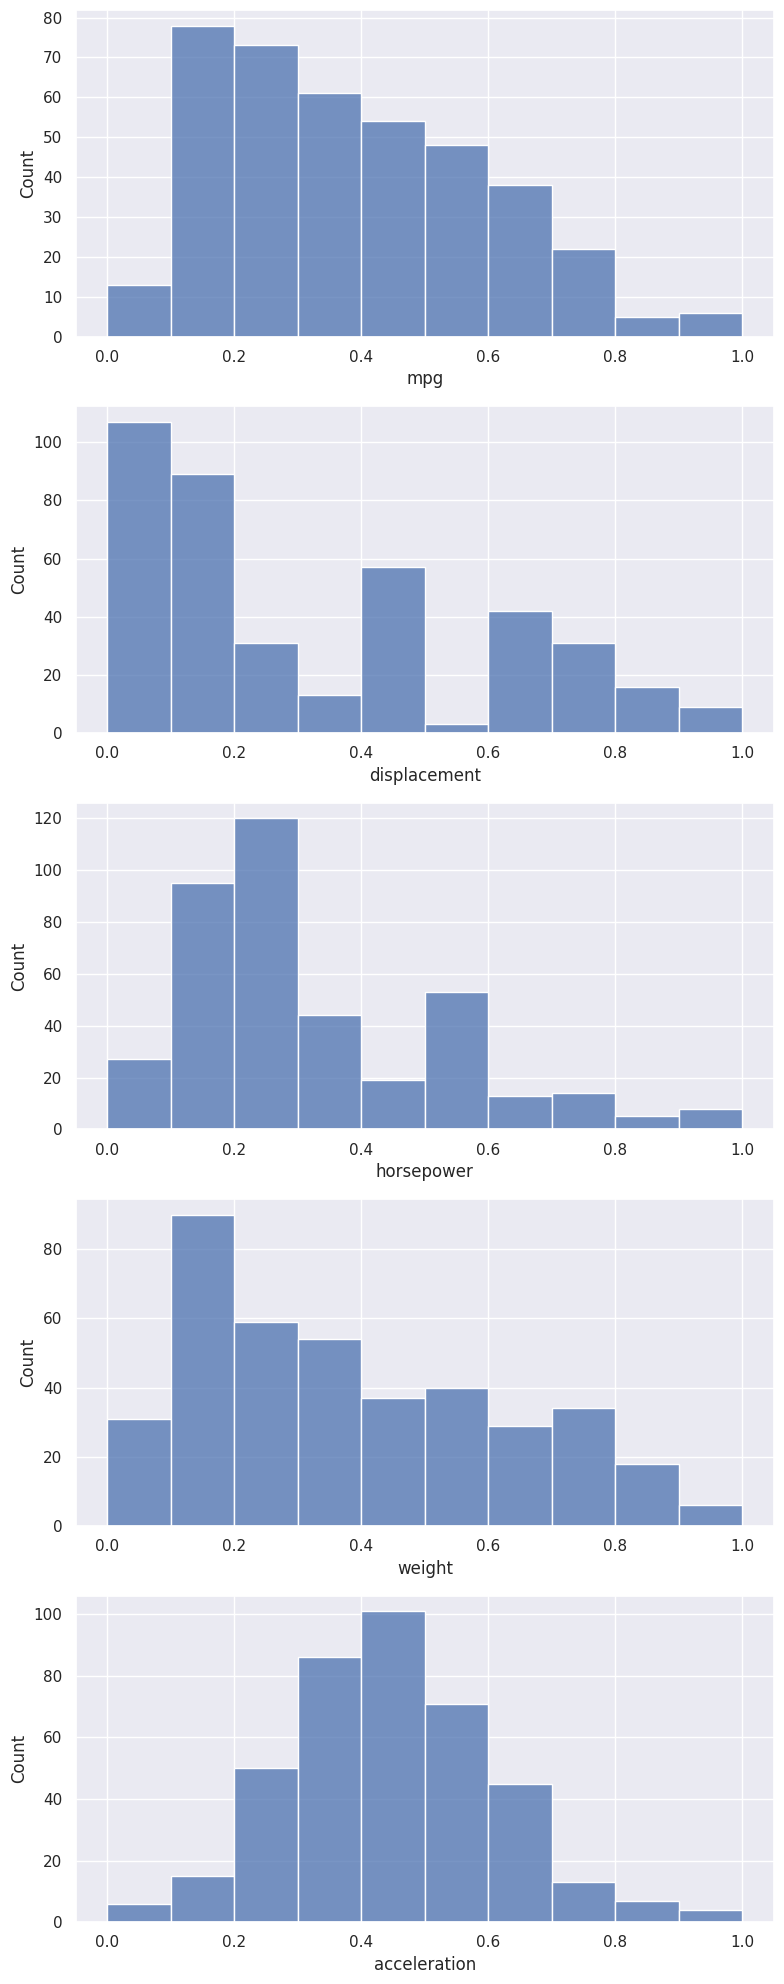

In [198]:
# Task 3
data2.ShowNormGraphs()

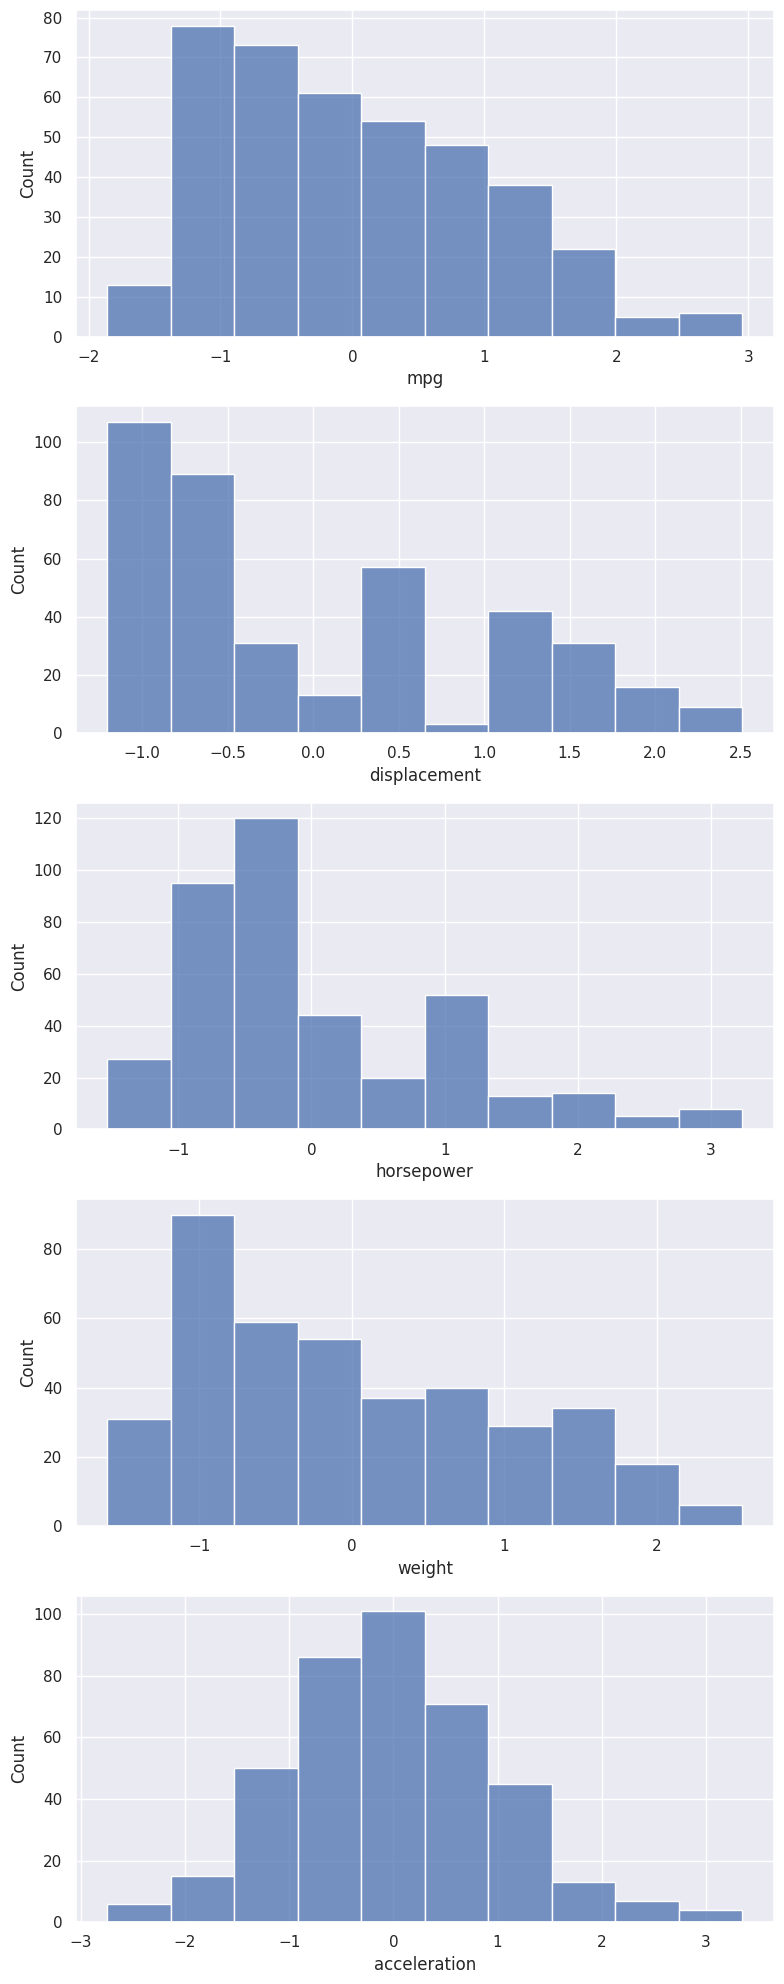

In [199]:
# Task 3
data2.ShowStandGraphs()

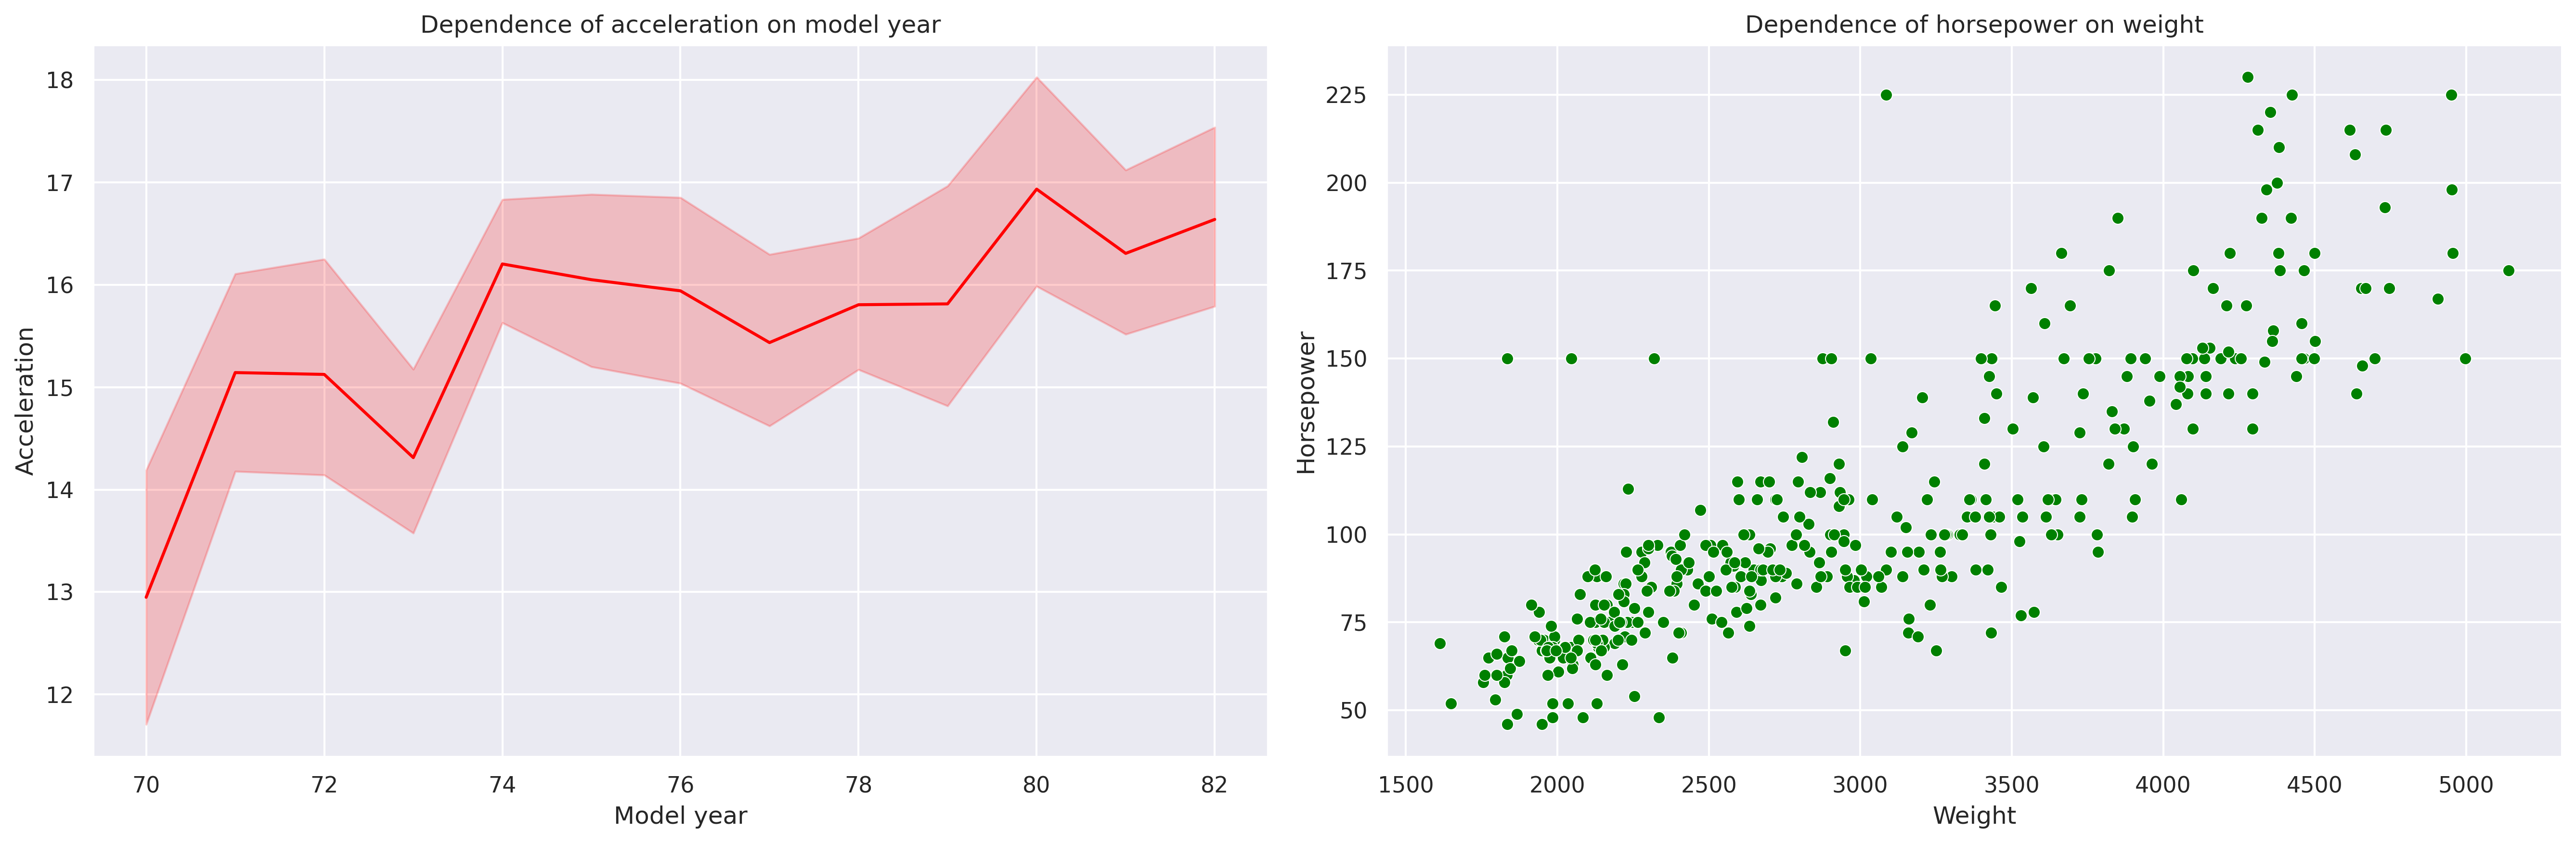

In [200]:
data2.BuildGraphRealInt()

In [201]:
data2.CalcCoef()


Pearson coeficient for MPG on Horsepower: -0.7531769820344797
Spearman coeficient coeficient for MPG on Horsepower: -0.8287826345112845

Pearson coeficient for Acceseleration on Model year: 0.2881369542994897
Spearman coeficient coeficient for Acceleration on Model year: 0.2746320976270586

Pearson coeficient for Horsepower on Weight: 0.8417699953578568
Spearman coeficient coeficient for Horsepower on Weight: 0.8536623290023647



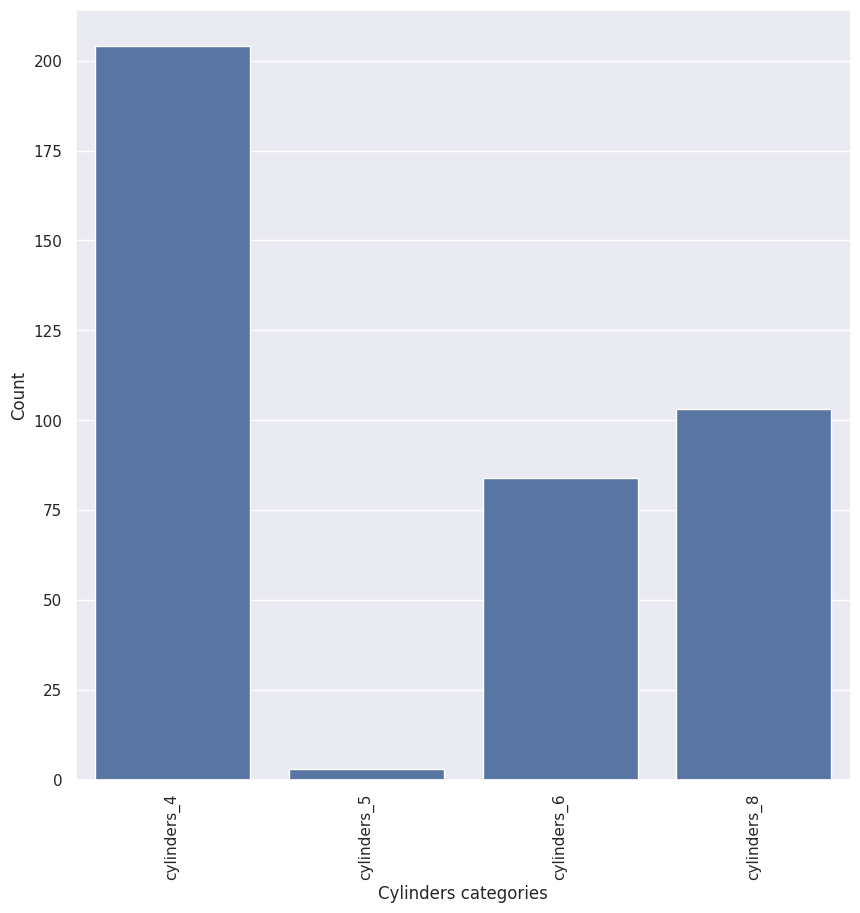

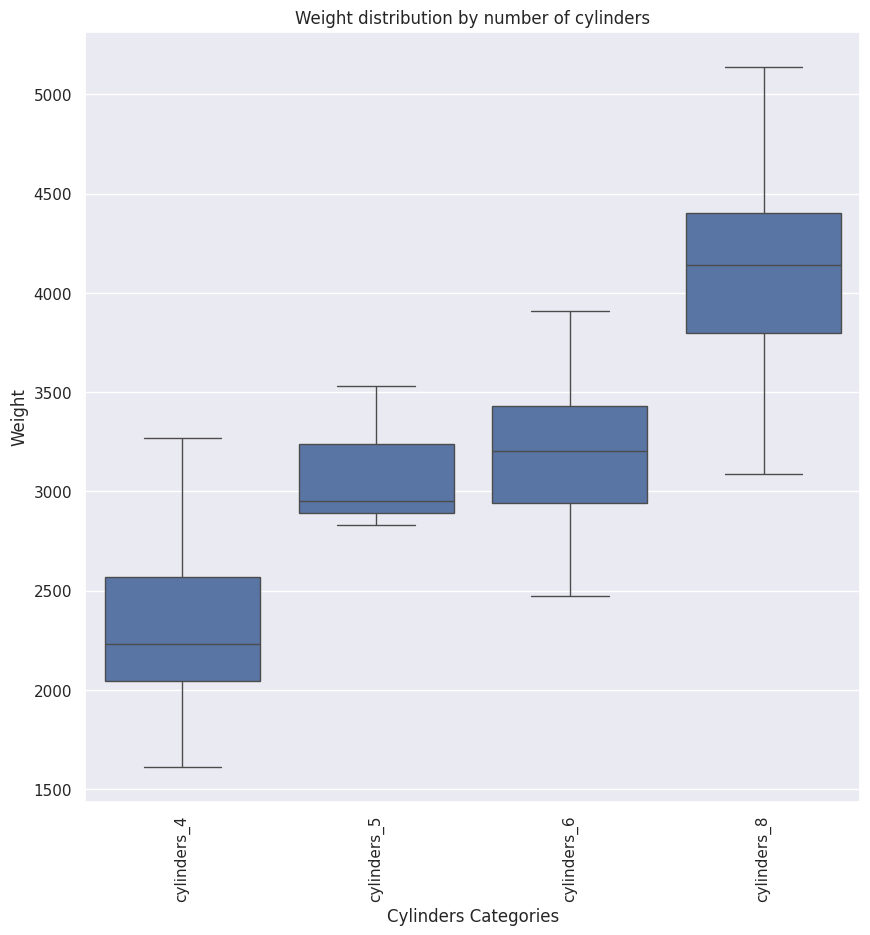

In [202]:
data2.OneHotEncoding()

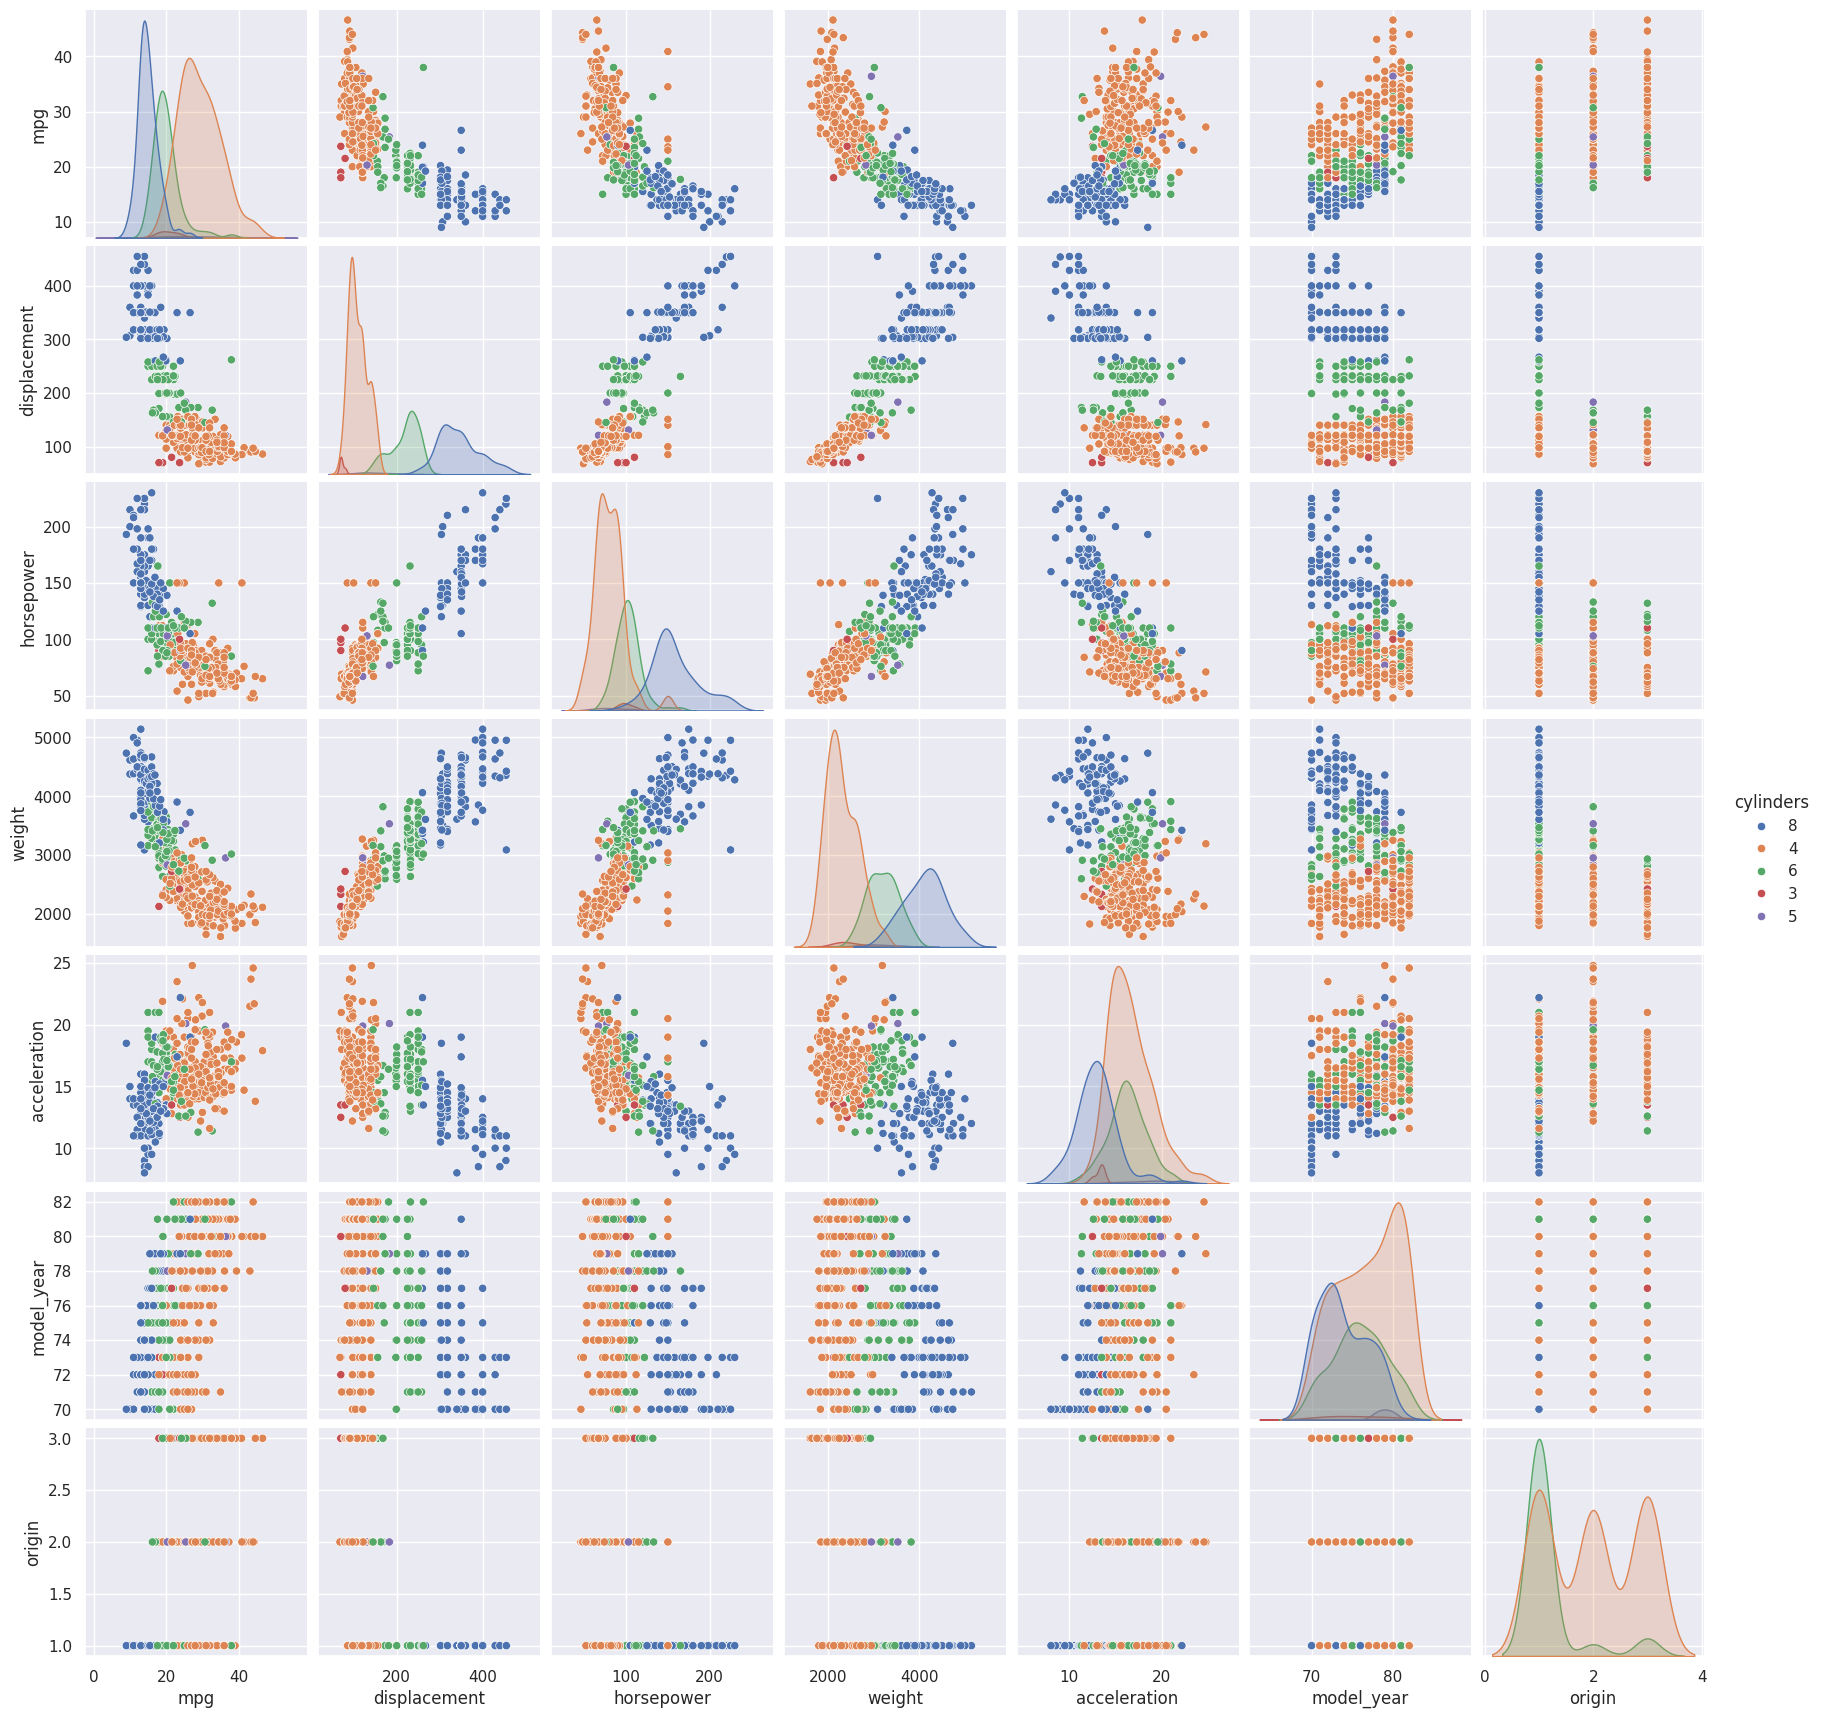

In [203]:
data2.BuildGraphForAllFeatures()

In [376]:
class DataPart2_NP(Data):
    def __init__(
            self,
            data_directory: str,
            data_filename_part: str,
            data_link: str, 
            data_archive_name: str,
            existing_data_filename: str
    ):
        super().__init__(
            data_directory,
            data_filename_part,
            data_link, 
            data_archive_name,
            existing_data_filename 
        )

        self.data_np_norm = None
        self.data_np_stand = None

        sns.set_theme(rc={'figure.figsize': (16, 10)})
    
    def ReplaceStrInFile(self, source_file, target_file, rstr, tstr):
        inputFile = open(source_file, "r") 
        exportFile = open(target_file, "w")
        for line in inputFile:
            new_line = line.replace(rstr, tstr)
            exportFile.write(new_line) 
        inputFile.close()
        exportFile.close()

    def PrepareDataNP(self):
        moded_data_filename = "moded_" + self.data_filename
        moded_data_filepath = os.path.join(self.data_directory, moded_data_filename)

        self.ReplaceStrInFile(
            self.data_filepath,
            moded_data_filepath,
            "\t",
            " "            
        )
        self.data_filename = moded_data_filename
        self.data_filepath = moded_data_filepath

        headers = [
            "mpg",
            "cylinders",
            "displacement",
            "horsepower",
            "weight",
            "acceleration",
            "model_year",
            "origin",
            "car_name",
        ]

        dtypes = [
            ("mpg", "f8"),
            ("cylinders", "int"),
            ("displacement", "f8"),
            ("horsepower", "f8"),
            ("weight", "f8"),
            ("acceleration", "f8"),
            ("model_year", "int"),
            ("origin", "int"),
            ("car_name", "U50"),
        ]

        # Із чистим numpy відкрити даний датасет доволі важко, бо в ньому наявні стрічки у лапках
        # всередині яких є пробільні симовли, колонки же датасету розділені також пробільними символами
        # genfromtxt не вміє розпізнавати лапки, тому все таким чином.
        # От би на С такого не було б, сам все своїми ручками зробив би як треба, а ці ваші пітони
        csv_form_data = csv.reader(open(self.data_filepath), delimiter=" ", skipinitialspace=True)

        self.data_np = np.genfromtxt(
            ("\t".join(i) for i in csv_form_data),
            delimiter='\t',
            dtype=dtypes,
            encoding=None,
            names=headers
        )


    def GetDataNP(self):
        if self.data_np is None:
            self.PrepareDataNP()
        return self.data_np

    
    #Task 1
    def FillMissValuesWithMean(self, columns):
        for col in columns:
            col_data = self.data_np[col]
            col_mean = np.nanmean(col_data)
            indeces = np.where(np.isnan(col_data))
            col_data[indeces] = col_mean
            self.data_np[col] = col_data


    #Task 2
    def Normalize(self, num_cols):
        self.data_np_norm = self.data_np.copy()
        type(self.data_np_norm)
        for col in num_cols:
            col_data = self.data_np[col]
            min_val = np.min(col_data)
            max_val = np.max(col_data)
            self.data_np_norm[col] = (col_data - min_val) / (max_val - min_val)
    
    def GetNormNP(self, num_cols=None):
        if self.data_np_norm is None:
            self.Normalize(num_cols)
        return self.data_np_norm

    def Standardize(self, num_cols):
        self.data_np_stand = self.data_np.copy()
        for col in num_cols:
            col_data = self.data_np[col]
            mean_val = np.mean(col_data)
            std_val = np.std(col_data)
            self.data_np_stand[col] = (col_data - mean_val) / std_val

    def GetStandNP(self, num_cols):
        if self.data_np_stand is None:
            self.Standardize(num_cols)
        
        return self.data_np_stand
    
    def BuildGraph(self):
        plt.scatter(
            x=self.data_np["horsepower"],
            y=self.data_np["mpg"],
            color="blue",     
            s=1
        )
        plt.xlabel("Horsepower")
        plt.ylabel("MPG")
        plt.show()

In [377]:
data2_np = DataPart2_NP(
    "data",
    "auto_mpg",
    "https://archive.ics.uci.edu/static/public/9/auto+mpg.zip",
    "auto-mpg.data",
    "auto_mpg_20240531234157.csv"#None
)

In [378]:
array2_np = data2_np.GetDataNP()
print(tabulate(array2_np[:20], headers="keys", tablefmt="psql"))


+-------+-------------+----------------+--------------+----------+----------------+--------------+----------+------------------------------+
|   mpg |   cylinders |   displacement |   horsepower |   weight |   acceleration |   model_year |   origin | car_name                     |
|-------+-------------+----------------+--------------+----------+----------------+--------------+----------+------------------------------|
|    18 |           8 |            307 |          130 |     3504 |           12   |           70 |        1 | chevrolet chevelle malibu    |
|    15 |           8 |            350 |          165 |     3693 |           11.5 |           70 |        1 | buick skylark 320            |
|    18 |           8 |            318 |          150 |     3436 |           11   |           70 |        1 | plymouth satellite           |
|    16 |           8 |            304 |          150 |     3433 |           12   |           70 |        1 | amc rebel sst                |
|    17 |    

In [379]:
#Task 1
data2_np.FillMissValuesWithMean(["horsepower"])

In [380]:
# Task 2
num_cols = [
    "mpg",
    "displacement",
    "horsepower",
    "weight",
    "acceleration",
]

np_arr_norm = data2_np.GetNormNP(num_cols)
print("\t\tNormalized array")
print(tabulate(np_arr_norm[:20], headers="keys", tablefmt="psql"))
print()

np_arr_stand = data2_np.GetStandNP(num_cols)
print("\t\tStandartized array")
print(tabulate(np_arr_stand[:20], headers="keys", tablefmt="psql"))
print()

		Normalized array
+----------+-------------+----------------+--------------+----------+----------------+--------------+----------+------------------------------+
|      mpg |   cylinders |   displacement |   horsepower |   weight |   acceleration |   model_year |   origin | car_name                     |
|----------+-------------+----------------+--------------+----------+----------------+--------------+----------+------------------------------|
| 0.239362 |           8 |      0.617571  |     0.456522 | 0.53615  |      0.238095  |           70 |        1 | chevrolet chevelle malibu    |
| 0.159574 |           8 |      0.728682  |     0.646739 | 0.589736 |      0.208333  |           70 |        1 | buick skylark 320            |
| 0.239362 |           8 |      0.645995  |     0.565217 | 0.51687  |      0.178571  |           70 |        1 | plymouth satellite           |
| 0.18617  |           8 |      0.609819  |     0.565217 | 0.516019 |      0.238095  |           70 |        1 | amc 

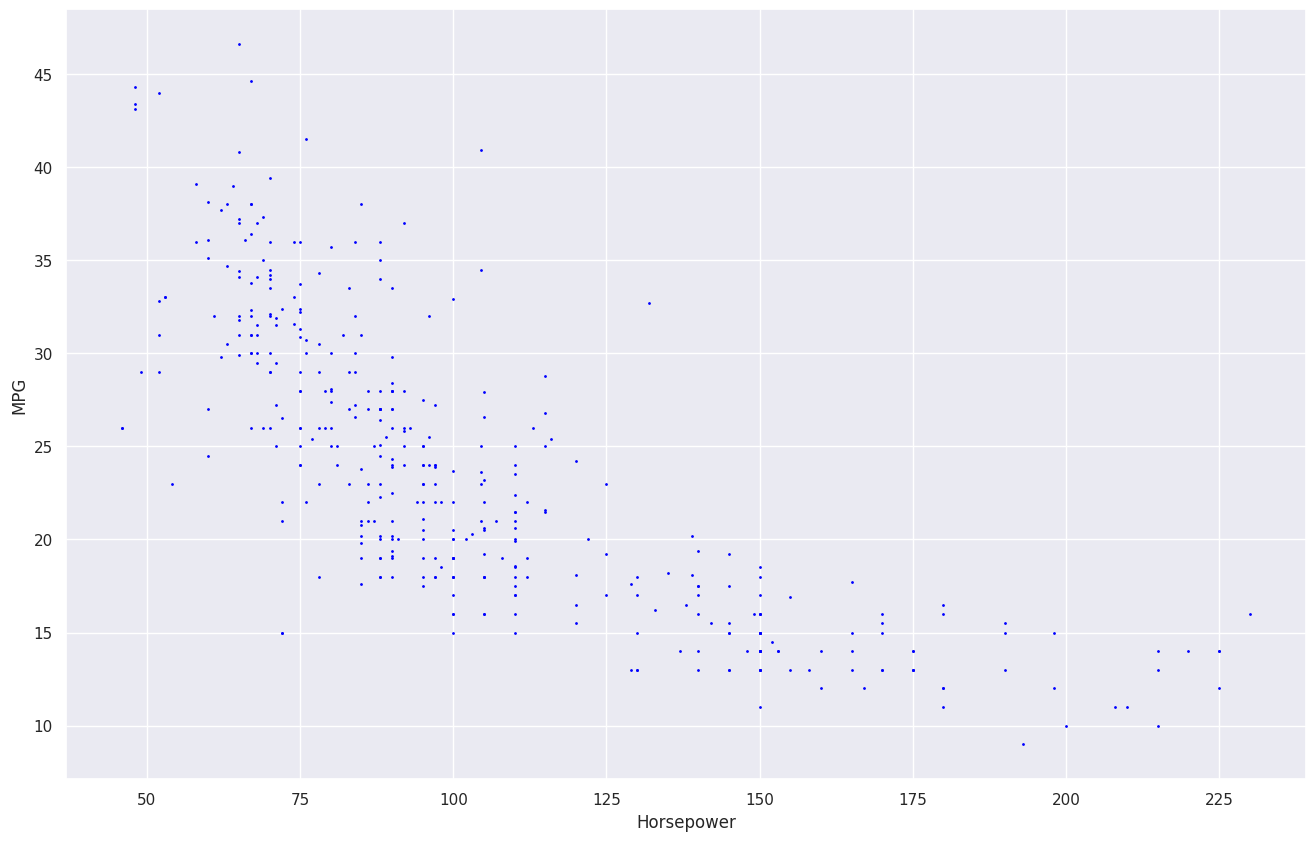

In [381]:
# Example of buildign graphs with numpy
data2_np.BuildGraph()